## 1. Importing Libraries

This block imports essential libraries for data analysis, visualization, statistics, and natural language processing. It sets the plotting style to 'ggplot' for consistent visuals.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
plt.style.use('ggplot')


## 2. NLTK and Scikit-learn Setup

This block imports NLTK modules for tokenization and stopword removal, downloads required NLTK data, and imports scikit-learn tools for TF-IDF vectorization and topic modeling.


In [2]:
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt', download_dir='C:\\nltk_data')
nltk.download('stopwords', download_dir='C:\\nltk_data')
nltk.download('punkt_tab')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\est_lul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 3. Load News Data

Attempts to load the financial news dataset from a Parquet file. If the file is missing or an error occurs, it prints an error message and exits.

In [3]:
try:
    # Load the parquet file
    news_df = pd.read_parquet('../../data/raw_analyst_ratings.parquet')
except FileNotFoundError:
    print("File not found. Please ensure the path is correct and the file exists.")
    exit(1)
except Exception as e:
    print(f"An error occurred while reading the parquet file: {e}")
    exit(1)

## 4. Data Preprocessing & Headline Statistics

Converts the date column to datetime, computes headline length in characters and words, and prints summary statistics (mean, median, std, min, max, skewness, kurtosis) for headline lengths. Shows a sample of the data.

In [4]:
# Convert date column to datetime format
news_df['date'] = pd.to_datetime(news_df['date'], format='mixed', utc=True)

# Compute headline text length metrics (character and word count)
news_df['headline_length_chars'] = news_df['headline'].apply(len)
news_df['headline_length_words'] = news_df['headline'].apply(lambda x: len(x.split()))

# Summary Statistics for Headline Length
headline_stats = {
    "Mean Length (Words)": np.mean(news_df['headline_length_words']),
    "Median Length (Words)": np.median(news_df['headline_length_words']),
    "Standard Deviation": np.std(news_df['headline_length_words']),
    "Max Length": np.max(news_df['headline_length_words']),
    "Min Length": np.min(news_df['headline_length_words']),
    "Skewness": stats.skew(news_df['headline_length_words']),
    "Kurtosis": stats.kurtosis(news_df['headline_length_words']),
}
print("Headline Length Statistics:\n", headline_stats)

news_df.sample(10)

Headline Length Statistics:
 {'Mean Length (Words)': np.float64(11.416705984674504), 'Median Length (Words)': np.float64(10.0), 'Standard Deviation': np.float64(6.352995020898485), 'Max Length': np.int64(77), 'Min Length': np.int64(1), 'Skewness': np.float64(2.1671569878139527), 'Kurtosis': np.float64(7.132395151646767)}


,Unnamed: 0,headline,url,publisher,date,stock,headline_length_chars,headline_length_words
1390153,1396635,Yen Rises Following S&P's Downgrade,https://www.benzinga.com/trading-ideas/long-id...,Emily Austin,2011-08-08 00:00:00+00:00,YCS,35,5
96865,97671,"Mid-Day Market Movers (NLST, CVBK, BMJ, ARTW)",https://www.benzinga.com/markets/company-news/...,Monica Gerson,2010-07-07 00:00:00+00:00,ARTW,45,7
1291792,1297970,Top Metal Mining Stocks to watch on 5/23/11- U...,https://www.benzinga.com/11/05/1103828/top-met...,CEO World,2011-05-23 00:00:00+00:00,URZ,127,24
843451,847754,Marathon Petroleum Corporation Reports Q1 EPS ...,https://www.benzinga.com/news/earnings/14/05/4...,Paul Quintaro,2014-05-01 00:00:00+00:00,MPC,89,14
417823,420074,Eastman Chemical Sees FY19 Adj. EPS $7.50-$8 v...,https://www.benzinga.com/news/19/07/14139059/e...,Benzinga Newsdesk,2019-07-25 00:00:00+00:00,EMN,62,10
1128397,1133926,Mizuho Maintains Neutral on Shell Midstream Pa...,https://www.benzinga.com/news/20/03/15693111/m...,Vick Meyer,2020-03-30 00:00:00+00:00,SHLX,80,12
830882,835137,Mid-Day Market Update: ULTA Salon Rises After ...,https://www.benzinga.com/news/earnings/14/06/4...,Garrett Cook,2014-06-11 00:00:00+00:00,MMYT,83,12
917554,922295,Mid-Afternoon Market Update: Dow Jumps Over 15...,https://www.benzinga.com/news/earnings/15/12/6...,Lisa Levin,2015-12-22 00:00:00+00:00,NTAP,99,14
226048,227474,Career Education Reports CFO AJ Cederoth To Le...,https://www.benzinga.com/news/17/09/10085305/c...,Paul Quintaro,2017-09-21 00:00:00+00:00,CECO,83,13
114764,115621,Qorvo and Skyworks Weigh Bids for Broadcom's R...,https://www.benzinga.com/m-a/20/01/15178667/qo...,Charles Gross,2020-01-24 00:00:00+00:00,AVGO,57,10


## 5. Temporal Analysis

Adds year, month, and hour columns to the dataset. Calculates and prints the number of news articles published per year, per month, and per hour to analyze temporal trends in news publication.

## 6. Publisher Analysis

Counts and displays the top publishers by the number of news articles published.

In [5]:
# Temporal Analysis of News Publications (Yearly and Monthly Trends)
news_df['year'] = news_df['date'].dt.year
news_df['month'] = news_df['date'].dt.month

yearly_counts = news_df.groupby('year')['headline'].count()
monthly_counts = news_df.groupby('month')['headline'].count()

# Time-of-Day Analysis (Are certain times more news-heavy?)
news_df['hour'] = news_df['date'].dt.hour
hourly_counts = news_df.groupby('hour')['headline'].count()

print("\nYearly News Article Counts:\n", yearly_counts)
print("\nMonthly News Article Counts:\n", monthly_counts)


print("\nHourly Distribution of News:\n", hourly_counts)


Yearly News Article Counts:
 year
2009     11489
2010     81319
2011    131322
2012    122649
2013    121529
2014    134859
2015    135295
2016    141892
2017    124456
2018    146924
2019    150380
2020    105214
Name: headline, dtype: int64

Monthly News Article Counts:
 month
1     121545
2     122836
3     121949
4     121813
5     130340
6     106598
7     110764
8     124041
9      96089
10    124800
11    121430
12    105123
Name: headline, dtype: int64

Hourly Distribution of News:
 hour
0     1351472
1          82
2          48
3          27
4          67
5          14
6          57
7          93
8        1469
9        1829
10       2476
11       5033
12       5527
13       5965
14       7669
15       5701
16       5732
17       2710
18       2075
19       1612
20       3939
21       2800
22        704
23        227
Name: headline, dtype: int64


In [6]:
publisher_counts = news_df['publisher'].groupby(news_df['publisher']).count().sort_values(ascending=False)
print("\nTop Publishers by News Count:\n", publisher_counts.head(10))


Top Publishers by News Count:
 publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: publisher, dtype: int64


## 7. Most Common Words in Headlines

Tokenizes all headlines, removes English stopwords, and counts word frequencies. Prints the top 10 most common words found in the headlines.

In [7]:
stop_words = set(stopwords.words('english'))

# Tokenize headlines and remove stop words
all_words = [word.lower() for headline in news_df['headline'] for word in word_tokenize(headline) 
             if word.isalpha() and word not in stop_words]

word_freq = Counter(all_words)

# Show top 10 most common words
print("\nTop 10 Most Common Words in Headlines:\n", word_freq.most_common(10))


Top 10 Most Common Words in Headlines:
 [('stocks', 161702), ('for', 154728), ('vs', 140965), ('in', 130298), ('eps', 128801), ('to', 124595), ('the', 122317), ('est', 122289), ('shares', 114140), ('reports', 108688)]


## 8. Top Bigram Keywords (TF-IDF)

Uses TF-IDF vectorization to extract the top 20 most important bigram (two-word) phrases from the headlines, ignoring English stopwords.

In [8]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2), max_features=20)
tfidf_matrix = vectorizer.fit_transform(news_df['headline'])

# Display top phrases with highest TF-IDF scores
print("\nTop Keywords from Financial News:\n", vectorizer.get_feature_names_out())


Top Keywords from Financial News:
 ['52 week' 'adj eps' 'benzinga upgrades' 'companies trading'
 'earnings scheduled' 'initiates coverage' 'market session'
 'market update' 'mid day' 'pre market' 'price target' 'q1 eps' 'q2 eps'
 'q3 eps' 'raises pt' 'stocks hit' 'stocks moving' 'trading higher'
 'trading lower' 'vs est']


## 9. Daily News Publication Trend Plot

Groups articles by date to count daily publications, then plots the number of articles published per day to visualize trends over time.

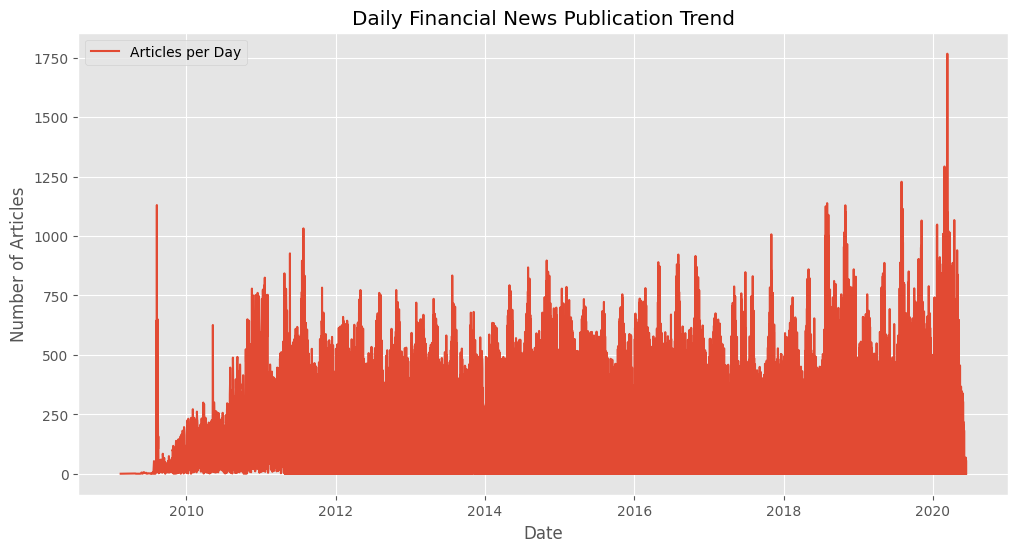

In [10]:
# Count articles published per day
daily_news_count = news_df.groupby('date').size().reset_index(name='num_articles')

# Plot publication frequency over time
plt.figure(figsize=(12,6))
plt.plot(daily_news_count['date'], daily_news_count['num_articles'], label='Articles per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Daily Financial News Publication Trend')
plt.legend()
plt.show()